
---


# **CS 4824/ECE 4424, Final Project**
##**Stock Market predictions based on historical trading data**
---



In [1]:
TF_USE_LEGACY_KERAS=True
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [2]:
!pip install torch
!pip install scikit-learn
!pip install tensorflow
#!pip install keras

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
import math
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

from keras.utils import to_categorical



---


# Data Filtering
---

In [4]:
# total number of data points : 8540
# number of data points that have data up to 2017 and start at least from 2013 : 361

In [5]:


folder_path = r"C:\Users\dasto\OneDrive - Virginia Tech\7 TH Semester\CS 4824\Final Project\archive\Data"

def extrac_data_with_time_limits(folder_path, initial_date_limit, last_date_limit):
    files_data_array = []
    files_name_array = []
    for root,dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    reader = csv.reader(f)
                    try:
                        header = next(reader)  # Skip the header
                    except StopIteration:
                        continue  # Skip the file if it is empty
                    rows = list(reader)
                    if not rows:
                        continue
                    # Define date limits
                    initial_date_str = rows[0][0]
                    last_date_str = rows[-1][0]
                    initial_date = datetime.strptime(initial_date_str, '%Y-%m-%d')
                    last_date = datetime.strptime(last_date_str, '%Y-%m-%d')
                    # Check if the data is within the time limits
                    if initial_date <= initial_date_limit and last_date >= last_date_limit:
                        # Filter out rows before 2003
                        filtered_rows = [row for row in rows if datetime.strptime(row[0], '%Y-%m-%d') >= initial_date_limit]                        
                        
                        # Convert all numeric values from strings to floats
                        for row in filtered_rows:
                            for i in range(1, len(row)):
                                row[i] = float(row[i])
                        
                        # Add the filtered data to the multidimensional array
                        files_data_array.append(filtered_rows)
                        # Add the text file name to an array. dimensions should match
                        file_name = file.split(".us")[0]
                        files_name_array.append(file_name)

    return files_data_array, files_name_array




In [6]:
# Call the function with the correct folder path and time limits
initial_date = datetime(2003, 2, 1)
final_date = datetime(2017, 1, 1)
filtered_time_data, filtered_time_data_names = extrac_data_with_time_limits(folder_path, initial_date, final_date )

In [7]:
print(len(filtered_time_data[1]))

3722


In [8]:
print(len(filtered_time_data))
print(len(filtered_time_data))

for i in range(len(filtered_time_data)):
    print(filtered_time_data[i][0][0])
    print(filtered_time_data_names[i])

361
361
2003-02-03
qqq
2003-02-03
a
2003-02-03
aa
2003-02-03
aaba
2003-02-03
aapl
2003-02-03
abc
2003-02-03
abt
2003-02-03
abx
2003-02-03
adbe
2003-02-03
adi
2003-02-03
adm
2003-02-03
admp
2003-02-03
adp
2003-02-03
adsk
2003-02-03
aee
2003-02-03
aem
2003-02-03
aep
2003-02-03
aes
2003-02-03
aet
2003-02-03
afl
2003-02-03
agn
2003-02-03
aig
2003-02-03
aiv
2003-02-03
all
2003-02-03
amat
2003-02-03
amd
2003-02-03
amgn
2003-02-03
amzn
2003-02-03
an
2003-02-03
antm
2003-02-03
apa
2003-02-03
apc
2003-02-03
apd
2003-02-03
aphb
2003-02-03
ash
2003-02-03
ati
2003-02-03
atro
2003-02-03
au
2003-02-03
avp
2003-02-03
avy
2003-02-03
axgn
2003-02-03
axp
2003-02-03
azo
2003-02-03
ba
2003-02-03
bac
2003-02-03
bax
2003-02-03
bb
2003-02-03
bbby
2003-02-03
bbt
2003-02-03
bby
2003-02-03
bc
2003-02-03
bcr
2003-02-03
bdx
2003-02-03
ben
2003-02-03
biib
2003-02-03
bk
2003-02-03
bll
2003-02-03
bms
2003-02-03
bmy
2003-02-03
brk-a
2003-02-03
brk-b
2003-02-03
bsx
2003-02-03
c
2003-02-03
ca
2003-02-03
cag
2003-02-03


---


# Model Visualization
---

The data has been filter by date. We have extracted the stocks that have data from 2003 to 2017

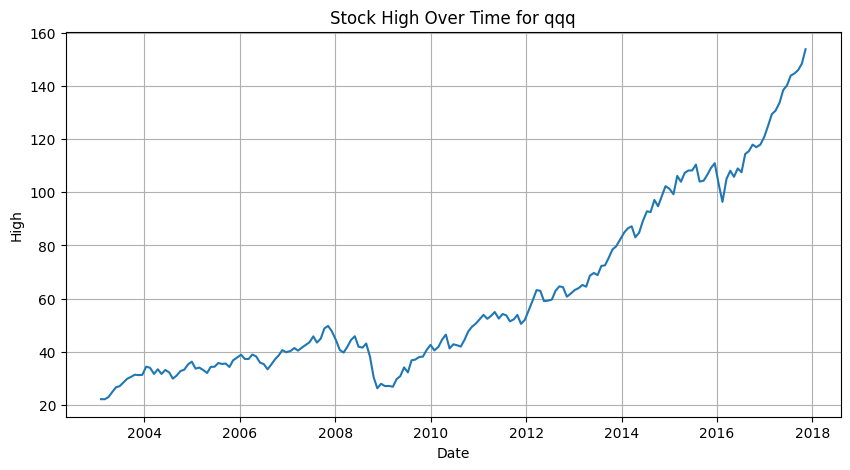

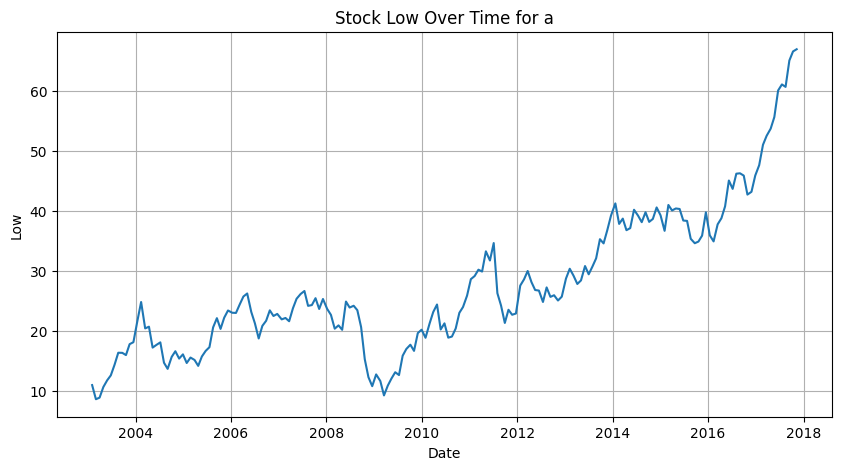

In [9]:
import pandas as pd

def plot_stock_price(stock_data, stock_name, parameter):
    # Define the index for each parameter
    parameter_index = {
        'Date': 0,
        'Open': 1,
        'High': 2,
        'Low': 3,
        'Close': 4,
        'Volume': 5,
        'OpenInt': 6
    }

    # Check if the parameter is valid
    if parameter not in parameter_index:
        raise ValueError(f"Invalid parameter: {parameter}. Choose from {list(parameter_index.keys())}")

    # Extract the data for the chosen parameter
    data = {
        'Date': [row[0] for row in stock_data],
        parameter: [float(row[parameter_index[parameter]]) for row in stock_data]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    #df[parameter] = pd.to_numeric(df[parameter])
    # Reduce the number of data points by selecting every 20th data point
    df_reduced = df.iloc[::20, :]

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(df_reduced['Date'], df_reduced[parameter])
    plt.title(f'Stock {parameter} Over Time for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel(parameter)
    plt.grid(True)
    plt.show()

plot_stock_price(filtered_time_data[0], filtered_time_data_names[0], 'High')
plot_stock_price(filtered_time_data[1], filtered_time_data_names[1], 'Low')

---


# Discrete Prediction
---

In [10]:
# Call the function with the correct folder path and time limits
initial_date = datetime(2003, 2, 1)
final_date = datetime(2017, 1, 1)
filtered_time_data, filtered_time_data_names = extrac_data_with_time_limits(folder_path, initial_date, final_date )
train_to_validation_ratio = 0.8

Let's try first with all features

In [80]:
# Create the training and validation datasets
#train_to_validation_ratio = 0.8
def generate_training_and_validation_data_discrete():
    
    num_training_samples = int(len(filtered_time_data)*train_to_validation_ratio)

    train_x = []
    train_y = []
    validation_x = []
    validation_y = []
    test_x = []
    test_y = []
    for i in range(num_training_samples):
        df = pd.DataFrame(filtered_time_data[i], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        training_values = df['2003':'2014'] #inclusive
        y_value = df['2015':'2017'] #inclusive
        y_value_growth = (y_value['Open'].iloc[0] - y_value['Close'].iloc[-1])/ y_value['Open'].iloc[0]
        train_x.append(training_values)
        train_y.append(y_value_growth)
        
    validation_x = train_x[-30:]
    validation_y = train_y[-30:]

    for i in range( len(filtered_time_data) - num_training_samples):
        index = i + num_training_samples
        df = pd.DataFrame(filtered_time_data[index], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        validation_values = df['2003':'2014'] #inclusive
        y_value = df['2015':'2017'] #inclusive
        y_value_growth = (y_value['Open'].iloc[0] - y_value['Close'].iloc[-1])/ y_value['Open'].iloc[0]
        test_x.append(validation_values)
        test_y.append(y_value_growth)

    return train_x, train_y, validation_x, validation_y, test_x, test_y


train_x, train_y, validation_x, validation_y, test_x, test_y = generate_training_and_validation_data()\

# Same function but we can define the number of year for the prediction
def generate_training_and_validation_data_discrete_by_year(years):
    
    num_training_samples = int(len(filtered_time_data)*train_to_validation_ratio)

    train_x = []
    train_y = []
    validation_x = []
    validation_y = []
    test_x = []
    test_y = []
    for i in range(num_training_samples):
        df = pd.DataFrame(filtered_time_data[i], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        training_values = df['2003':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = (y_value['Open'].iloc[0] - y_value['Close'].iloc[-1])/ y_value['Open'].iloc[0]
        train_x.append(training_values)
        train_y.append(y_value_growth)
        
    validation_x = train_x[-30:]
    validation_y = train_y[-30:]

    for i in range( len(filtered_time_data) - num_training_samples):
        index = i + num_training_samples
        df = pd.DataFrame(filtered_time_data[index], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        validation_values = df['2003':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = (y_value['Open'].iloc[0] - y_value['Close'].iloc[-1])/ y_value['Open'].iloc[0]
        test_x.append(validation_values)
        test_y.append(y_value_growth)

    return train_x, train_y, validation_x, validation_y, test_x, test_y



In [85]:

def prepare_keras_input(data_list, custom_features, scaler=None):
    # Collect feature data
    feature_arrays = []
    for df in data_list:
        features = df[custom_features].values  # Select features
        if scaler:
            features = scaler.transform(features)  # Normalize
        feature_arrays.append(features)
    
    # Ensure all feature arrays have the same shape
    max_timesteps = max(len(features) for features in feature_arrays)
    for i in range(len(feature_arrays)):
        if len(feature_arrays[i]) < max_timesteps:
            padding = np.zeros((max_timesteps - len(feature_arrays[i]), feature_arrays[i].shape[1]))
            feature_arrays[i] = np.vstack((feature_arrays[i], padding))
    
    # Convert to NumPy array
    feature_arrays = np.array(feature_arrays)
    
    return feature_arrays
def custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, custom_features):
    # Create a MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data
    all_train_features = np.concatenate([df[custom_features].values for df in x_train])
    scaler.fit(all_train_features)

    # Prepare input data
    train_x_prepared = prepare_keras_input(x_train, custom_features, scaler=scaler )
    validation_x_prepared = prepare_keras_input(x_val, custom_features, scaler=scaler)
    test_x_prepared = prepare_keras_input(x_test, custom_features, scaler=scaler)

    # Convert targets to NumPy arrays
    train_y_prepared = np.array(y_train)
    validation_y_prepared = np.array(y_val)
    test_y_prepared = np.array(y_test)

    return train_x_prepared, train_y_prepared, validation_x_prepared, validation_y_prepared, test_x_prepared, test_y_prepared

In [40]:
def base_cnn_regression(input_shape):
    """
    Define a convolutional neural network for regression using the Sequential model.
    
    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        
    Returns:
        model (Sequential): Compiled CNN model.
    """
    model = Sequential()
    
    # Add 1D convolution layers
    model.add(Conv1D(32, 3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv1D(32, 3, padding='same'))
    model.add(Activation('relu'))
    
    # Perform MaxPooling operation
    model.add(MaxPooling1D(pool_size=2))
    
    # Add a Dropout layer
    model.add(Dropout(0.25))
    
    # Create another stack of (Conv1D, Activation) layers
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Activation('relu'))
    
    # Perform MaxPooling and Dropout
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # Flatten the 1D data to 1D
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Create the output layer for regression
    model.add(Dense(1))  # Single output for regression
    
    # Set the optimizer
    opt = RMSprop(learning_rate=0.0001, decay=1e-6)
    
    # Compile the model
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mean_squared_error'])
    
    print(model.summary())
    
    return model

In [42]:
batch_size = 32
epochs = 20

In [ ]:
#isolate this line to avoid remaking erasing content from dictionary
history_activations = dict()

In [ ]:


name = 'All features'
features = ['Open', 'High', 'Low', 'Close', 'Volume']
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(train_x, train_y, validation_x, validation_y, test_x, test_y, features)
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
save_best_model = ModelCheckpoint('best_model.{}.keras'.format(name), monitor='val_mean_squared_error', mode='min', save_best_only=True, verbose=1)
model = base_cnn_regression(input_shape)
history_activations[name] = model.fit(x_train, y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data=(x_val, y_val),
                                            shuffle=True,
                                            callbacks=[save_best_model])

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 3000, 32)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,599,201 (93.84 MB)

 Trainable params: 24,599,201 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.6352 - mean_squared_error: 1.6352
Epoch 1: val_mean_squared_error improved from inf to 0.16347, saving model to best_model.All features.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 1.5482 - mean_squared_error: 1.5482 - val_loss: 0.1635 - val_mean_squared_error: 0.1635
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.3286 - mean_squared_error: 1.3286
Epoch 2: val_mean_squared_error improved from 0.16347 to 0.15754, saving model to best_model.All features.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - loss: 1.2650 - mean_squared_error: 1.2650 - val_loss: 0.1575 - val_mean_squared_error: 0.1575
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.3108 - mean_squared_error: 1.3108
Epoch 3: val_mean_squared_error did not improve from 0.15754
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 1.2478 - mean_squared_error: 1.2478 - val_loss: 0.1604 - val_mean_squared_error: 0.1604
Epoch 4/20
9/9 ━━━━━━━━━━━━

In [46]:
name = 'Open_and_Volume'
features = ['Open','Volume']
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(train_x, train_y, validation_x, validation_y, test_x, test_y, features)
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
save_best_model = ModelCheckpoint('best_model.{}.keras'.format(name), monitor='val_mean_squared_error', mode='min', save_best_only=True, verbose=1)
model = base_cnn_regression(input_shape)
history_activations[name] = model.fit(x_train, y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data=(x_val, y_val),
                                            shuffle=True,
                                            callbacks=[save_best_model])


C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.6323 - mean_squared_error: 0.6323
Epoch 1: val_mean_squared_error improved from inf to 0.15755, saving model to best_model.Open_and_Volume.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - loss: 0.6441 - mean_squared_error: 0.6441 - val_loss: 0.1576 - val_mean_squared_error: 0.1576
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.6443 - mean_squared_error: 0.6443
Epoch 2: val_mean_squared_error did not improve from 0.15755
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.6487 - mean_squared_error: 0.6487 - val_loss: 0.1602 - val_mean_squared_error: 0.1602
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.0371 - mean_squared_error: 1.0371
Epoch 3: val_mean_squared_error did not improve from 0.15755
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 1.0019 - mean_squared_error: 1.0019 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.5980 - mean_squ

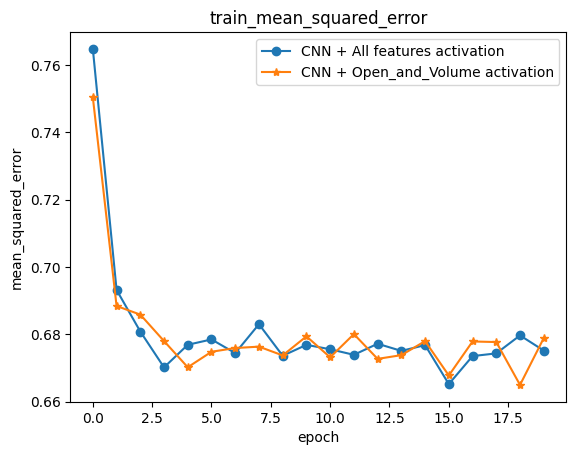

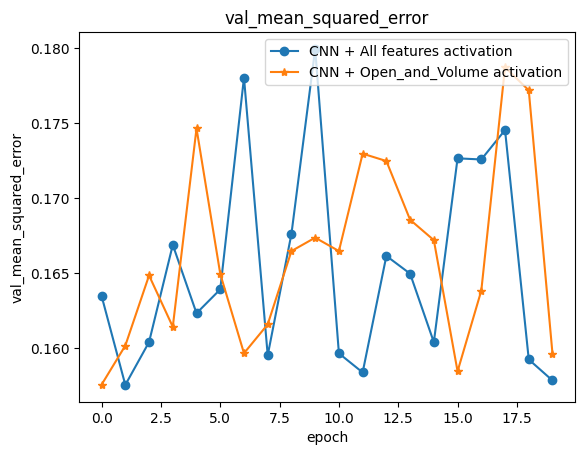

In [51]:
#print(history_activations[features].history.keys())
plt.plot(history_activations['All features'].history['mean_squared_error'], 'o-', label='CNN + {} activation'.format('All features'))
plt.plot(history_activations['Open_and_Volume'].history['mean_squared_error'], '*-', label='CNN + {} activation'.format('Open_and_Volume'))
plt.title('train_mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

plt.plot(history_activations['All features'].history['val_mean_squared_error'], 'o-', label='CNN + {} activation'.format('All features'))
plt.plot(history_activations['Open_and_Volume'].history['val_mean_squared_error'], '*-', label='CNN + {} activation'.format('Open_and_Volume'))
plt.title('val_mean_squared_error')
plt.ylabel('val_mean_squared_error')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


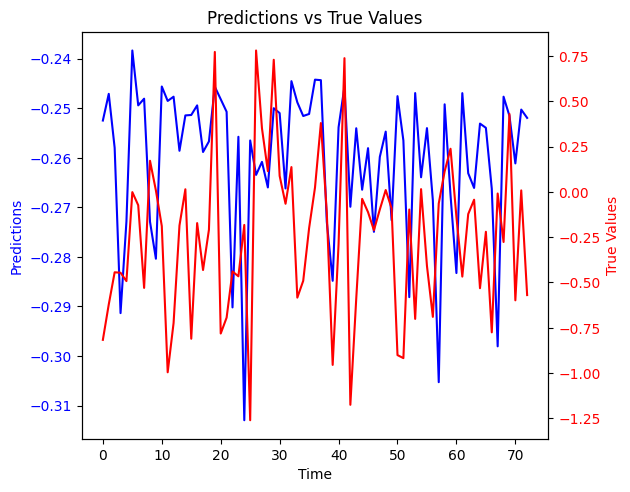

In [49]:

# Make predictions on the test set
predictions = model.predict(x_test)

# If you used a scaler, reverse the scaling for the predictions
# Assuming you used a MinMaxScaler for the target values


# Print the predictions
#print("Predictions:", predictions)
# Plot the predictions and true values on different scales
fig, ax1 = plt.subplots()

# Plot predictions on the primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Predictions', color='blue')
ax1.plot(predictions, label='Predictions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot the true values
ax2 = ax1.twinx()
ax2.set_ylabel('True Values', color='red')
ax2.plot(y_test, label='True Values', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
plt.title('Predictions vs True Values')
plt.show()

From the experiments conducted, we can concluded that predicted a discrete value does not yield accurate results. I suspect that it is because we are trying to predict too far into the future. Before moving to a boolean prediction (good or bad investment), I want to prove my hyphothesis by developing a model that predicts the stock price change at different times in the future, in increments of 1 year

In [ ]:
# Call the function with the correct folder path and time limits
initial_date = datetime(2003, 2, 1)
years = '2015'
features = ['Open', 'Volume']
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_discrete_by_year(years)
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)
print(y_train[0],y_train[-1])
print(y_train.shape)

-0.08891752577319587 0.07349926793557818
-0.08891752577319587 0.07349926793557818
(288,)


C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 1: val_mean_squared_error improved from inf to 0.02474, saving model to best_model.2015.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 2: val_mean_squared_error improved from 0.02474 to 0.02380, saving model to best_model.2015.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 3: val_mean_squared_error improved from 0.02380 to 0.02297, saving model to best_model.2015.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0230 - val_mean_squared_error: 0.0230


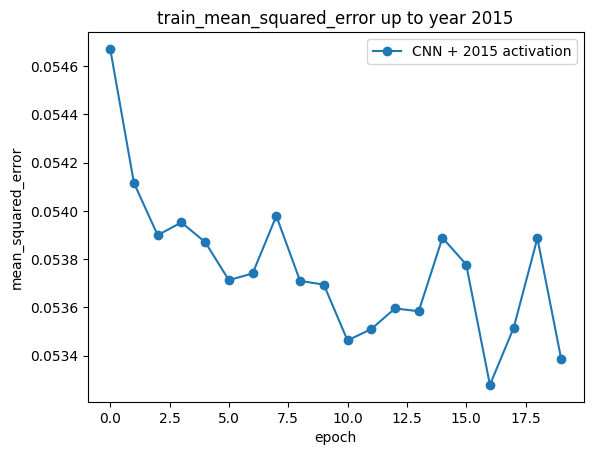

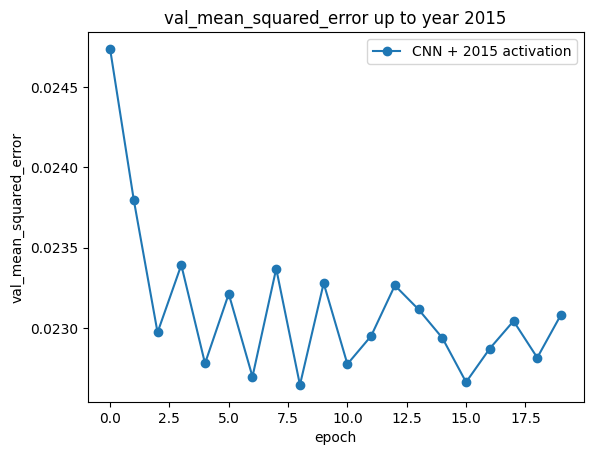

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)              │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2214 - mean_squared_error: 0.2214
Epoch 1: val_mean_squared_error improved from inf to 0.06945, saving model to best_model.2016.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1423 - mean_squared_error: 0.1423
Epoch 2: val_mean_squared_error did not improve from 0.06945
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1472 - mean_squared_error: 0.1472 - val_loss: 0.0718 - val_mean_squared_error: 0.0718
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2849 - mean_squared_error: 0.2849
Epoch 3: val_mean_squared_error did not improve from 0.06945
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.2751 - mean_squared_error: 0.2751 - val_loss: 0.0699 - val_mean_squared_error: 0.0699
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2890 - mean_squared_error:

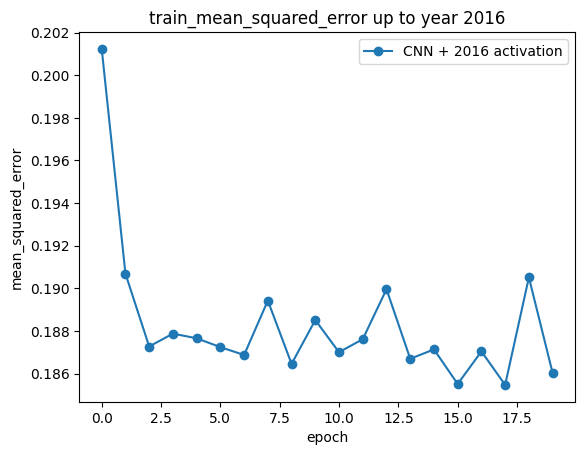

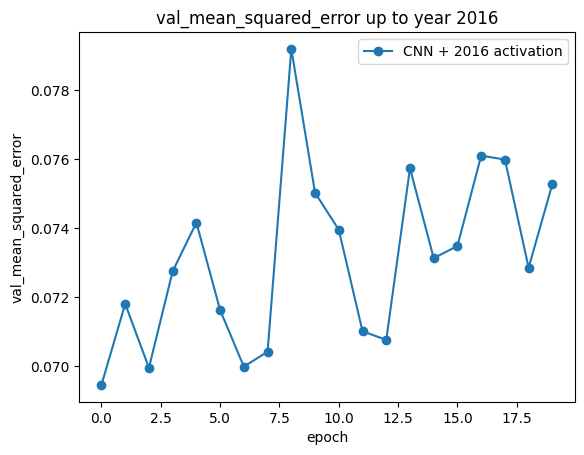

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.0275 - mean_squared_error: 1.0275
Epoch 1: val_mean_squared_error improved from inf to 0.15795, saving model to best_model.2017.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 0.9998 - mean_squared_error: 0.9998 - val_loss: 0.1579 - val_mean_squared_error: 0.1579
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.5241 - mean_squared_error: 0.5241
Epoch 2: val_mean_squared_error did not improve from 0.15795
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.5407 - mean_squared_error: 0.5407 - val_loss: 0.1698 - val_mean_squared_error: 0.1698
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.4874 - mean_squared_error: 0.4874
Epoch 3: val_mean_squared_error did not improve from 0.15795
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.5065 - mean_squared_error: 0.5065 - val_loss: 0.1728 - val_mean_squared_error: 0.1728
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.4206 - mean_squared_error:

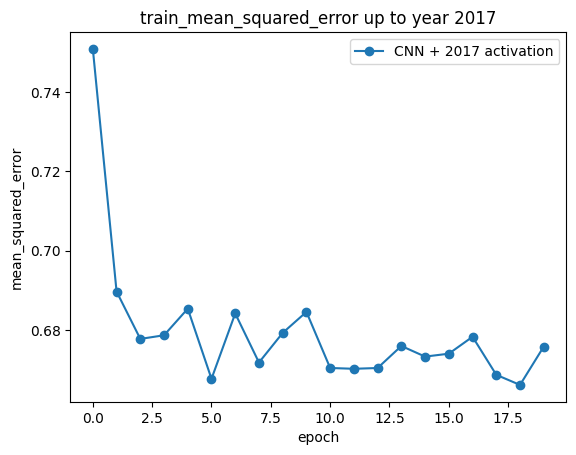

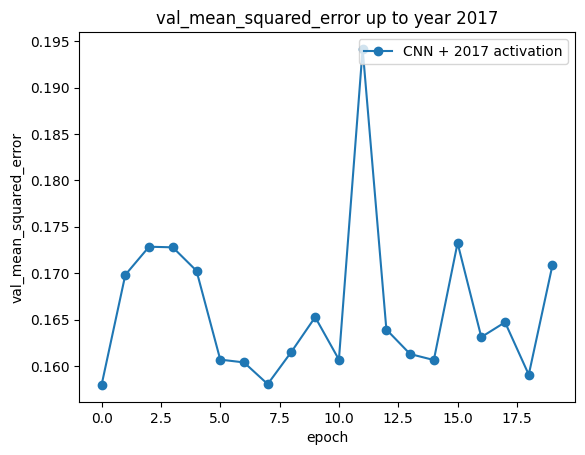

In [89]:
years = ['2015', '2016', '2017']
features = ['Open', 'Volume']
for year in years :
    x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_discrete_by_year(year)
    x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)
    input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
    save_best_model = ModelCheckpoint('best_model.{}.keras'.format(year), monitor='val_mean_squared_error', mode='min', save_best_only=True, verbose=1)
    model = base_cnn_regression(input_shape)
    history_activations[year] = model.fit(x_train, y_train,
                                                batch_size=batch_size,
                                                epochs=epochs,
                                                validation_data=(x_val, y_val),
                                                shuffle=True,
                                                callbacks=[save_best_model])

    plt.plot(history_activations[year].history['mean_squared_error'], 'o-', label='CNN + {} activation'.format(year))
    plt.title('train_mean_squared_error up to year {}'.format(year))
    plt.ylabel('mean_squared_error')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()

    plt.plot(history_activations[year].history['val_mean_squared_error'], 'o-', label='CNN + {} activation'.format(year))
    plt.title('val_mean_squared_error up to year {}'.format(year))
    plt.ylabel('val_mean_squared_error')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()

Text(0.5, 0, 'Year')

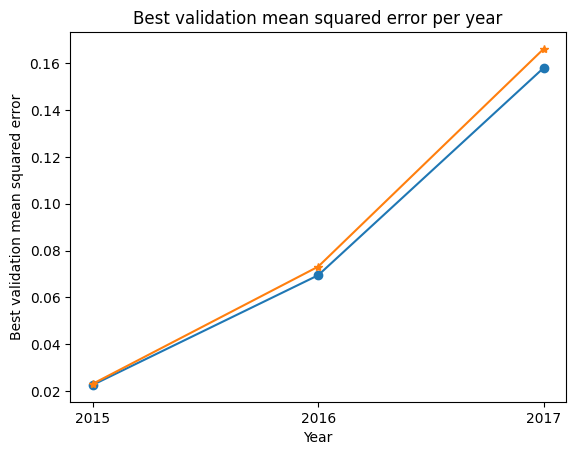

In [96]:
best_runs_per_year = []
average_runs_value_per_year = []
for year in years:
    best_run = min(history_activations[year].history['val_mean_squared_error'])
    average_value = sum(history_activations[year].history['val_mean_squared_error'])/len(history_activations[year].history['val_mean_squared_error'])
    best_runs_per_year.append(best_run)
    average_runs_value_per_year.append(average_value)
plt.plot(years, best_runs_per_year, 'o-', label = 'Best run')
plt.plot(years, average_runs_value_per_year, '*-', label = 'Average run')
plt.title('Best validation mean squared error per year')
plt.ylabel('Best validation mean squared error')
plt.xlabel('Year')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


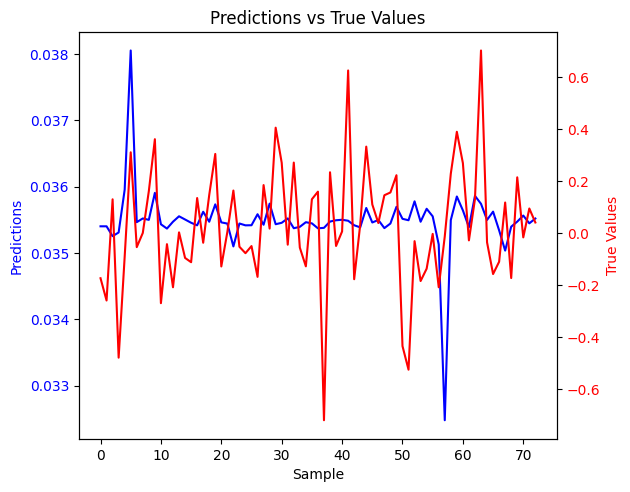

In [100]:
model = history_activations['2015'].model
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_discrete_by_year('2015')
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)
predictions = model.predict(x_test)

fig, ax1 = plt.subplots()

# Plot predictions on the primary y-axis
ax1.set_xlabel('Sample')
ax1.set_ylabel('Predictions', color='blue')
ax1.plot(predictions, label='Predictions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot the true values
ax2 = ax1.twinx()
ax2.set_ylabel('True Values', color='red')
ax2.plot(y_test, label='True Values', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
plt.title('Predictions vs True Values')
plt.show()

From our experiment we can determine that, as eexpected, the further in the future we try to predict the stock value, the greater the mean squared error.Even with the best run, our model fails to predict the stock price change. Let's try to implement a boolean model now.

---


# Boolean Clasifier
---

to start our experiment we will need to modify our function to generate training, validation, and test data. We will also incorporate two new parameter that lets us choose what is a "good" stock growth and the time that into the future we analyze it. 

The Base CNN model will also need to be modified to predict boolean values, as well as how we construct our model.

In [173]:
# Same function but we can define the number of year for the prediction
year = ['2016']
threshold = 0.1 # 5% threshold
def generate_training_and_validation_data_boolean_by_year(years, threshold):
    
    num_training_samples = int(len(filtered_time_data)*train_to_validation_ratio)
    train_x = []
    train_y = []
    validation_x = []
    validation_y = []
    test_x = []
    test_y = []
    for i in range(num_training_samples):
        df = pd.DataFrame(filtered_time_data[i], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        training_values = df['2003':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = 0 if (y_value['Close'].iloc[-1] - y_value['Open'].iloc[0])/ y_value['Open'].iloc[0] < threshold else 1
        train_x.append(training_values)
        train_y.append(y_value_growth)
        
    validation_x = train_x[-30:]
    validation_y = train_y[-30:]

    for i in range( len(filtered_time_data) - num_training_samples):
        index = i + num_training_samples
        df = pd.DataFrame(filtered_time_data[index], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        validation_values = df['2003':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = 0 if (y_value['Close'].iloc[-1] - y_value['Open'].iloc[0])/ y_value['Open'].iloc[0] < threshold else 1
        test_x.append(validation_values)
        test_y.append(y_value_growth)

    return train_x, train_y, validation_x, validation_y, test_x, test_y



In [234]:
def base_cnn_opt(input_shape, optimizer):
    """
    Define a convolutional neural network for regression using the Sequential model.
    
    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        
    Returns:
        model (Sequential): Compiled CNN model.
    """
    model = Sequential()
    
    # Add 1D convolution layers
    model.add(Conv1D(32, 3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv1D(32, 3, padding='same'))
    model.add(Activation('relu'))
    
    # Perform MaxPooling operation
    model.add(MaxPooling1D(pool_size=2))
    
    # Add a Dropout layer
    model.add(Dropout(0.1))
    
    model.add(Conv1D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Conv1D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Create another stack of (Conv1D, Activation) layers
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Activation('relu'))
    
    # Perform MaxPooling and Dropout
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    # Flatten the 1D data to 1D
    model.add(Flatten())
    #model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Create the output layer for regression
    model.add(Dense(1))  # Single output for binary classification
    model.add(Activation('sigmoid'))  # Sigmoid activation for binary classification
    

    if optimizer == 'RMSprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
    elif optimizer == 'Adagrad':
      opt = tf.keras.optimizers.Adagrad()
    else:
      raise ValueError('Invalid optimizer')

    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [235]:
history_discrete_optimizers = dict()

In [236]:
year = '2017'
threshold = 0.1
epochs = 5
batch_size = 64
features = ['Open', 'Volume']
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_boolean_by_year(year, threshold)
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)

In [205]:
print(y_train)

[1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0
 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0]


C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_531 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_781 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_532 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_782 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_265               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_397 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_533 (Conv1D)             │ (None, 126, 128)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_783 (Activation)     │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_266               │ (None, 63, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_534 (Conv1D)             │ (None, 63, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_784 (Activation)     │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_267               │ (None, 31, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_535 (Conv1D)             │ (None, 31, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_785 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_536 (Conv1D)             │ (None, 31, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_786 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_268               │ (None, 15, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_398 (Dropout)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_132 (Flatten)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_787 (Activation)     │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_399 (Dropout)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │           961 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_788 (Activation)     │ (None, 1)              │             

 Total params: 102,977 (402.25 KB)

 Trainable params: 102,977 (402.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5799 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model.RMSprop.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5788 - loss: 0.6930 - val_accuracy: 0.5333 - val_loss: 0.6927
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5798 - loss: 0.6923
Epoch 2: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5763 - loss: 0.6923 - val_accuracy: 0.5333 - val_loss: 0.6926
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5219 - loss: 0.6933
Epoch 3: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5286 - loss: 0.6932 - val_accuracy: 0.5333 - val_loss: 0.6925
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5625 - loss: 0.6921
Epoch 4: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5597 - loss: 0.6920 - val

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_537 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_789 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_538 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_790 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_269               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_400 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_539 (Conv1D)             │ (None, 126, 128)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_791 (Activation)     │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_270               │ (None, 63, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_540 (Conv1D)             │ (None, 63, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_792 (Activation)     │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_271               │ (None, 31, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_541 (Conv1D)             │ (None, 31, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_793 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_542 (Conv1D)             │ (None, 31, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_794 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_272               │ (None, 15, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_401 (Dropout)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_133 (Flatten)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_795 (Activation)     │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_402 (Dropout)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 1)              │           961 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_796 (Activation)     │ (None, 1)              │             

 Total params: 102,977 (402.25 KB)

 Trainable params: 102,977 (402.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5850 - loss: 0.6925
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model.Adam.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5821 - loss: 0.6926 - val_accuracy: 0.5333 - val_loss: 0.6916
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5308 - loss: 0.6915
Epoch 2: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5355 - loss: 0.6911 - val_accuracy: 0.5333 - val_loss: 0.6908
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5727 - loss: 0.6863
Epoch 3: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5710 - loss: 0.6865 - val_accuracy: 0.5333 - val_loss: 0.6914
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5560 - loss: 0.6873
Epoch 4: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5571 - loss: 0.6873 - val_ac

Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_543 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_797 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_544 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_798 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_273               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_403 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_545 (Conv1D)             │ (None, 126, 128)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_799 (Activation)     │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_274               │ (None, 63, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_546 (Conv1D)             │ (None, 63, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_800 (Activation)     │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_275               │ (None, 31, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_547 (Conv1D)             │ (None, 31, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_801 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_548 (Conv1D)             │ (None, 31, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_802 (Activation)     │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_276               │ (None, 15, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_404 (Dropout)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_134 (Flatten)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_803 (Activation)     │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_405 (Dropout)           │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 1)              │           961 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_804 (Activation)     │ (None, 1)              │             

 Total params: 102,977 (402.25 KB)

 Trainable params: 102,977 (402.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4688 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model.Adagrad.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5312 - loss: 0.6932 - val_accuracy: 0.5333 - val_loss: 0.6930
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5469 - loss: 0.6931
Epoch 2: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5410 - loss: 0.6931 - val_accuracy: 0.5333 - val_loss: 0.6929
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4688 - loss: 0.6935
Epoch 3: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5440 - loss: 0.6930 - val_accuracy: 0.5333 - val_loss: 0.6929
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5781 - loss: 0.6925
Epoch 4: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5605 - loss: 0.6926 - val_ac

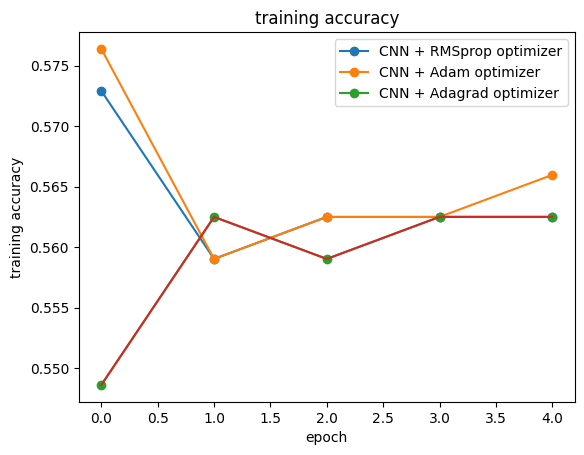

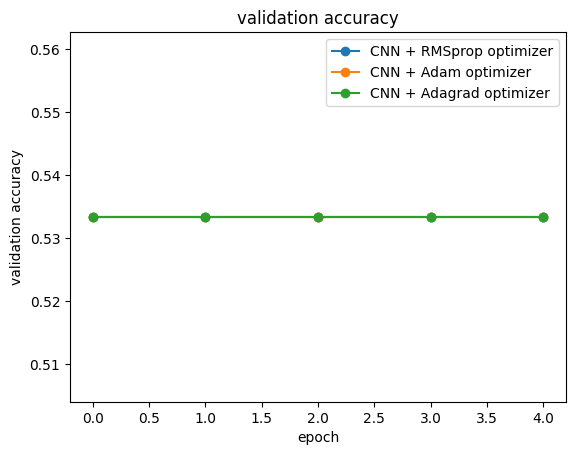

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5504 - loss: 0.6926 
Test accuracy for CNN + RMSprop optimizer: 0.5616438388824463
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5504 - loss: 0.6907 
Test accuracy for CNN + Adam optimizer: 0.5616438388824463
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5504 - loss: 0.6930 
Test accuracy for CNN + Adagrad optimizer: 0.5616438388824463


In [237]:

year = '2016'
threshold = 0.1
epochs = 5
batch_size = 64
features = ['Open', 'Volume']
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_boolean_by_year(year, threshold)
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)

for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  save_best_model = ModelCheckpoint('best_model.{}.keras'.format(optimizer), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
  model = base_cnn_opt(input_shape, optimizer)
  history_discrete_optimizers[optimizer] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val, y_val),
                          shuffle=True,
                          callbacks=[save_best_model])

# Plot training accuracy
for model_name, history in history_discrete_optimizers.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_discrete_optimizers.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  saved_model = load_model('best_model.{}.keras'.format(optimizer))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(optimizer, scores[1]))

The accuracy reaches a limit at 80 % when using year 2016. We will try year 2017.

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_364 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_533 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_365 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_534 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_182               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_366 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_535 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_367 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_536 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_183               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_91 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_537 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_538 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6317 - loss: 0.6923
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model.RMSprop.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.6329 - loss: 0.6922 - val_accuracy: 0.6667 - val_loss: 0.6890
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6527 - loss: 0.6876
Epoch 2: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.6562 - loss: 0.6871 - val_accuracy: 0.6667 - val_loss: 0.6772
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6889 - loss: 0.6701
Epoch 3: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.6863 - loss: 0.6697 - val_accuracy: 0.6667 - val_loss: 0.6576
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7014 - loss: 0.6390
Epoch 4: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.6968 - loss: 0.640

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_368 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_539 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_369 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_540 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_184               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_370 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_541 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_371 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_542 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_185               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_92 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_543 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_544 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6601 - loss: 0.6719
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model.Adam.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.6617 - loss: 0.6698 - val_accuracy: 0.6667 - val_loss: 0.6483
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6686 - loss: 0.6452
Epoch 2: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.6694 - loss: 0.6446 - val_accuracy: 0.6667 - val_loss: 0.6347
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6735 - loss: 0.6322
Epoch 3: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.6735 - loss: 0.6326 - val_accuracy: 0.6667 - val_loss: 0.6382
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6574 - loss: 0.6380
Epoch 4: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.6601 - loss: 0.6363 -

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_372 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_545 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_373 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_546 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_186               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_374 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_547 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_375 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_548 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_187               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_93 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_549 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_550 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5109 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model.Adagrad.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.5230 - loss: 0.6932 - val_accuracy: 0.6667 - val_loss: 0.6922
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6477 - loss: 0.6922
Epoch 2: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6503 - loss: 0.6922 - val_accuracy: 0.6667 - val_loss: 0.6912
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6490 - loss: 0.6918
Epoch 3: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.6519 - loss: 0.6917 - val_accuracy: 0.6667 - val_loss: 0.6902
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6586 - loss: 0.6905
Epoch 4: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.6599 - loss: 0.690

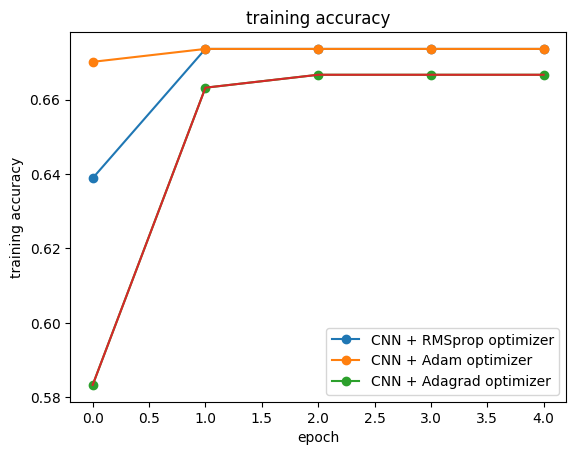

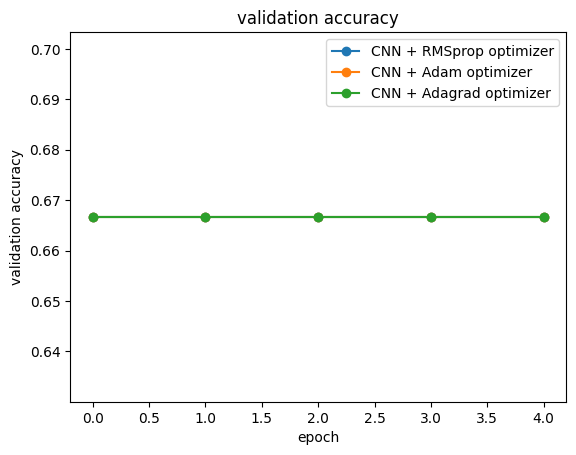

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6061 - loss: 0.6906 
Test accuracy for CNN + RMSprop optimizer: 0.6027397513389587
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6061 - loss: 0.6733 
Test accuracy for CNN + Adam optimizer: 0.6027397513389587
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6061 - loss: 0.6925 
Test accuracy for CNN + Adagrad optimizer: 0.6027397513389587


In [179]:
year = '2017'
threshold = 0.1
epochs = 5
batch_size = 64
features = ['Open', 'Volume']
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_boolean_by_year(year, threshold)
x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)

for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  save_best_model = ModelCheckpoint('best_model.{}.keras'.format(optimizer), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
  model = base_cnn_opt(input_shape, optimizer)
  history_discrete_optimizers[optimizer] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val, y_val),
                          shuffle=True,
                          callbacks=[save_best_model])

# Plot training accuracy
for model_name, history in history_discrete_optimizers.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_discrete_optimizers.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  saved_model = load_model('best_model.{}.keras'.format(optimizer))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(optimizer, scores[1]))

Accuracy didn't improve. It seems that that the accuracy does not get impacted by the optimizer. Let's pick the Adam optmizer for future test. 
Now we would test the accuracy under different threshold limits, 0.05, 0.1, 0.15, 0.2 

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_380 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_557 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_381 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_558 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_190               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_285 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_382 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_559 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_383 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_560 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_191               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_95 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_561 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_562 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6580 - loss: 0.6927
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to best_model_with_threshold.0.001.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - accuracy: 0.6652 - loss: 0.6926 - val_accuracy: 0.7333 - val_loss: 0.6906
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7473 - loss: 0.6898
Epoch 2: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7483 - loss: 0.6897 - val_accuracy: 0.7333 - val_loss: 0.6880
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7528 - loss: 0.6870
Epoch 3: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7529 - loss: 0.6869 - val_accuracy: 0.7333 - val_loss: 0.6855
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7265 - loss: 0.6851
Epoch 4: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.7310 

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_384 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_563 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_385 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_564 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_192               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_386 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_565 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_387 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_566 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_193               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_96 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_567 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_568 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6310 - loss: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to best_model_with_threshold.0.01.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.6421 - loss: 0.6925 - val_accuracy: 0.7333 - val_loss: 0.6910
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7461 - loss: 0.6905
Epoch 2: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.7467 - loss: 0.6904 - val_accuracy: 0.7333 - val_loss: 0.6889
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7442 - loss: 0.6885
Epoch 3: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7457 - loss: 0.6884 - val_accuracy: 0.7333 - val_loss: 0.6870
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7627 - loss: 0.6860
Epoch 4: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.7611 -

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_388 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_569 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_389 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_570 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_194               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_390 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_571 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_391 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_572 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_195               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_97 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_573 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_574 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6243 - loss: 0.6928
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to best_model_with_threshold.0.05.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.6308 - loss: 0.6928 - val_accuracy: 0.7000 - val_loss: 0.6917
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7053 - loss: 0.6914
Epoch 2: val_accuracy did not improve from 0.70000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.7070 - loss: 0.6913 - val_accuracy: 0.7000 - val_loss: 0.6902
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7144 - loss: 0.6898
Epoch 3: val_accuracy did not improve from 0.70000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.7163 - loss: 0.6898 - val_accuracy: 0.7000 - val_loss: 0.6888
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7297 - loss: 0.6877
Epoch 4: val_accuracy did not improve from 0.70000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.7296 -

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_392 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_575 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_393 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_576 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_196               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_394 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_577 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_395 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_578 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_197               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_98 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_579 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_580 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6135 - loss: 0.6929
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model_with_threshold.0.1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.6155 - loss: 0.6929 - val_accuracy: 0.6667 - val_loss: 0.6918
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6874 - loss: 0.6914
Epoch 2: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6845 - loss: 0.6914 - val_accuracy: 0.6667 - val_loss: 0.6905
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6579 - loss: 0.6902
Epoch 3: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.6605 - loss: 0.6902 - val_accuracy: 0.6667 - val_loss: 0.6890
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6876 - loss: 0.6878
Epoch 4: val_accuracy did not improve from 0.66667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6853 - 

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_396 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_581 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_397 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_582 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_198               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_398 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_583 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_399 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_584 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_199               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_99 (Flatten)            │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_585 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_586 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5838 - loss: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model_with_threshold.0.15.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.5877 - loss: 0.6926 - val_accuracy: 0.6000 - val_loss: 0.6928
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5726 - loss: 0.6927
Epoch 2: val_accuracy did not improve from 0.60000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5819 - loss: 0.6927 - val_accuracy: 0.6000 - val_loss: 0.6923
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6185 - loss: 0.6922
Epoch 3: val_accuracy did not improve from 0.60000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.6196 - loss: 0.6922 - val_accuracy: 0.6000 - val_loss: 0.6920
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6323 - loss: 0.6916
Epoch 4: val_accuracy did not improve from 0.60000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.6311 -

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_400 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_587 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_401 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_588 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_200               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_402 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_589 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_403 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_590 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_201               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_301 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_100 (Flatten)           │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_591 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_302 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_592 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5250 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to best_model_with_threshold.0.2.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.5243 - loss: 0.6932 - val_accuracy: 0.5667 - val_loss: 0.6930
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5579 - loss: 0.6930
Epoch 2: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.5564 - loss: 0.6931 - val_accuracy: 0.5667 - val_loss: 0.6928
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5631 - loss: 0.6928
Epoch 3: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.5624 - loss: 0.6928 - val_accuracy: 0.5667 - val_loss: 0.6927
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5925 - loss: 0.6924
Epoch 4: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5852 - 

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_404 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_593 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_405 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_594 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_202               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_406 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_595 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_407 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_596 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_203               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_101 (Flatten)           │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_597 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_305 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_598 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5265 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model_with_threshold.0.25.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.5226 - loss: 0.6931 - val_accuracy: 0.5333 - val_loss: 0.6931
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5386 - loss: 0.6934
Epoch 2: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.5351 - loss: 0.6933 - val_accuracy: 0.5333 - val_loss: 0.6931
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5353 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.5318 - loss: 0.6932 - val_accuracy: 0.5333 - val_loss: 0.6931
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4830 - loss: 0.6933
Epoch 4: val_accuracy did not improve from 0.53333
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.4864 -

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_408 (Conv1D)             │ (None, 3000, 32)       │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_599 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_409 (Conv1D)             │ (None, 3000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_600 (Activation)     │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_204               │ (None, 1500, 32)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_306 (Dropout)           │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_410 (Conv1D)             │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_601 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_411 (Conv1D)             │ (None, 1500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_602 (Activation)     │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_205               │ (None, 750, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_307 (Dropout)           │ (None, 750, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_102 (Flatten)           │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 512)            │    24,576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_603 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_308 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_604 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,598,913 (93.84 MB)

 Trainable params: 24,598,913 (93.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5429 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to best_model_with_threshold.0.3.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.5433 - loss: 0.6931 - val_accuracy: 0.5667 - val_loss: 0.6929
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5428 - loss: 0.6928
Epoch 2: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.5420 - loss: 0.6928 - val_accuracy: 0.5667 - val_loss: 0.6928
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5228 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5248 - loss: 0.6932 - val_accuracy: 0.5667 - val_loss: 0.6927
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5344 - loss: 0.6926
Epoch 4: val_accuracy did not improve from 0.56667
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.5356 - 

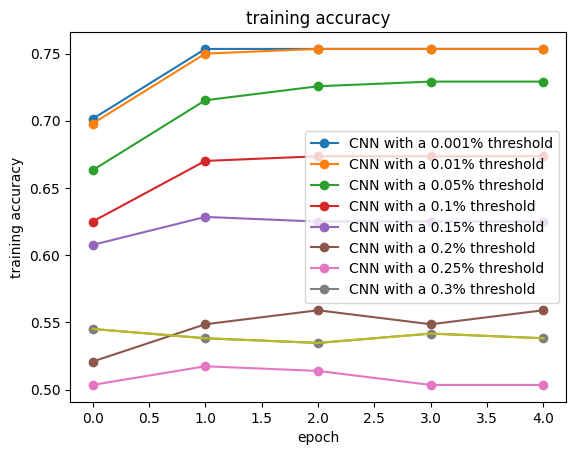

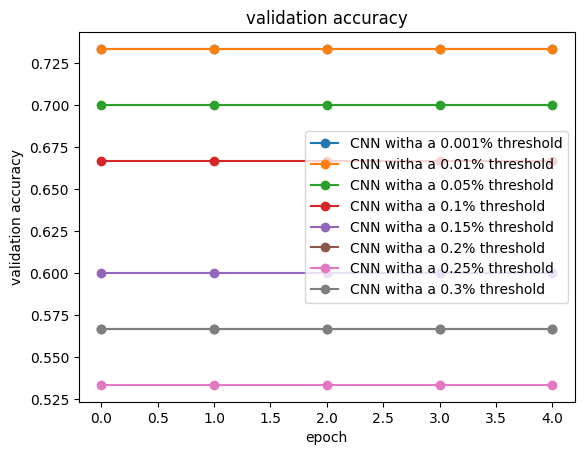

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7331 - loss: 0.6906 
Test accuracy for CNN + 0.001 optimizer: 0.7397260069847107
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7077 - loss: 0.6912 
Test accuracy for CNN + 0.01 optimizer: 0.7123287916183472
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6862 - loss: 0.6918 
Test accuracy for CNN + 0.05 optimizer: 0.6849315166473389
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6061 - loss: 0.6924 
Test accuracy for CNN + 0.1 optimizer: 0.6027397513389587
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5630 - loss: 0.6929 
Test accuracy for CNN + 0.15 optimizer: 0.5479452013969421
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4780 - loss: 0.6932 
Test accuracy for CNN + 0.2 optimizer: 0.4794520437717438
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4418 - loss: 0.6932 
Test accuracy for CNN + 0.25 optimizer: 0.4383561611175537
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5758 - loss: 0.6929 
Test

In [181]:
history_discrete_thresholds = dict()
year = '2017'
epochs = 5
batch_size = 64
features = ['Open', 'Volume']
optmizer = 'Adam'
x_test_holder = []
y_test_holder = []
thresholds = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for threshold in thresholds:
    x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_boolean_by_year(year, threshold)
    x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)
    save_best_model = ModelCheckpoint('best_model_with_threshold.{}.keras'.format(threshold), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
    model = base_cnn_opt(input_shape, optimizer)
    history_discrete_thresholds[threshold] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val, y_val),
                          shuffle=True,
                          callbacks=[save_best_model])
    x_test_holder.append(x_test)
    y_test_holder.append(y_test)

# Plot training accuracy
for model_name, history in history_discrete_thresholds.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN with a {}% threshold'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_discrete_thresholds.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN witha a {}% threshold'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
index = 0
for threshold in thresholds:
  saved_model = load_model('best_model_with_threshold.{}.keras'.format(threshold))
  scores = saved_model.evaluate(x_test_holder[index], y_test_holder[index], verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(threshold, scores[1]))
  index += 1

The higher we set the threshold, the higher the accuracy. This could be because the higher the the threshold, the lest likely the stocks are going to have a high increase in their value. 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7331 - loss: 0.6906 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7077 - loss: 0.6912 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6862 - loss: 0.6918 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6061 - loss: 0.6924 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5630 - loss: 0.6929 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4780 - loss: 0.6932 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4418 - loss: 0.6932 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5758 - loss: 0.6929 


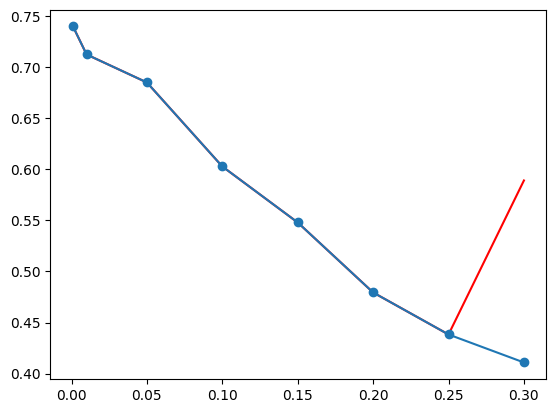

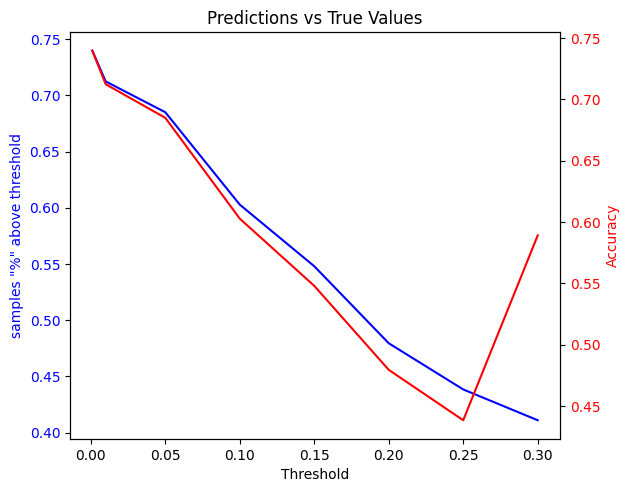

In [182]:
index = 0
accuracy_array = []
for threshold in thresholds:
  saved_model = load_model('best_model_with_threshold.{}.keras'.format(threshold))
  scores = saved_model.evaluate(x_test_holder[index], y_test_holder[index], verbose=1)
  accuracy_array.append(scores[1])
  index += 1

positive_count_array = []
for y in y_test_holder:
    positive_count = 0
    for i in range(len(y)):
        if y[i] == 1:
            positive_count += 1
    positive_count_array.append(positive_count/len(y))



plt.plot(thresholds, accuracy_array, 'r-')
plt.plot(thresholds, positive_count_array, 'o-')

fig, ax1 = plt.subplots()

# Plot predictions on the primary y-axis
ax1.set_xlabel('Threshold')
ax1.set_ylabel('samples "%" above threshold', color='blue')
ax1.plot(thresholds, positive_count_array,  label='Positives', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot the true values
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(thresholds, accuracy_array, label='Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
plt.title('Predictions vs True Values')
plt.show()


After 10 percent, only a small portion of our data increases its stock value by more than the threshold value.
Only 25 % of our test data increases in stock value which could be a problem when training our model. All of our models are predicting true values, which explains the direct correlation to the sample % above threshold


In [183]:
model = load_model('best_model_with_threshold.{}.keras'.format('0.05'))
predictions = model.predict(x_test_holder[2])
print(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[0.50174713]
 [0.50167215]
 [0.5017724 ]
 [0.50212246]
 [0.5018785 ]
 [0.5017847 ]
 [0.501717  ]
 [0.5017282 ]
 [0.501839  ]
 [0.5019355 ]
 [0.5016935 ]
 [0.50169337]
 [0.50170076]
 [0.50180155]
 [0.5017439 ]
 [0.50173604]
 [0.50172174]
 [0.50182074]
 [0.5017679 ]
 [0.5016937 ]
 [0.5016998 ]
 [0.50171673]
 [0.5020732 ]
 [0.50182045]
 [0.50210226]
 [0.50175333]
 [0.50190794]
 [0.501806  ]
 [0.50189716]
 [0.5017084 ]
 [0.5017403 ]
 [0.5018817 ]
 [0.501673  ]
 [0.5017202 ]
 [0.5017389 ]
 [0.50174975]
 [0.50166446]
 [0.50167   ]
 [0.50195897]
 [0.50195515]
 [0.5017624 ]
 [0.50168073]
 [0.50186837]
 [0.5017437 ]
 [0.5018885 ]
 [0.50178885]
 [0.5018735 ]
 [0.5017936 ]
 [0.50174963]
 [0.50194883]
 [0.50170916]
 [0.5017884 ]
 [0.5019647 ]
 [0.5016989 ]
 [0.50177896]
 [0.50178134]
 [0.50196654]
 [0.50157726]
 [0.5017348 ]
 [0.50183374]
 [0.50198704]
 [0.5017085 ]
 [0.5020035 ]
 [0.5018563 ]
 [0.5017591 ]
 [0.50176954]
 [0.50184846]
 [0.50213075]
 [0.50171

Let's try one more time. This time we will use less datapoints.We will only look at one year history of the stock

In [ ]:
#Let's redefine the function to set the training data starting at 2014
def generate_training_and_validation_data_boolean_by_year(years, threshold):
    
    num_training_samples = int(len(filtered_time_data)*train_to_validation_ratio)
    train_x = []
    train_y = []
    validation_x = []
    validation_y = []
    test_x = []
    test_y = []
    for i in range(num_training_samples):
        df = pd.DataFrame(filtered_time_data[i], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        training_values = df['2014':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = 0 if (y_value['Close'].iloc[-1] - y_value['Open'].iloc[0])/ y_value['Open'].iloc[0] < threshold else 1
        train_x.append(training_values)
        train_y.append(y_value_growth)
        
    validation_x = train_x[-30:]
    validation_y = train_y[-30:]

    for i in range( len(filtered_time_data) - num_training_samples):
        index = i + num_training_samples
        df = pd.DataFrame(filtered_time_data[index], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        validation_values = df['2014':'2014'] #inclusive
        y_value = df['2015':years] #inclusive
        y_value_growth = 0 if (y_value['Close'].iloc[-1] - y_value['Open'].iloc[0])/ y_value['Open'].iloc[0] < threshold else 1
        test_x.append(validation_values)
        test_y.append(y_value_growth)

    return train_x, train_y, validation_x, validation_y, test_x, test_y

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_499 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_733 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_500 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_734 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_249               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_373 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_501 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_735 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_502 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_736 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_250               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_374 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_124 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_737 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_375 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_738 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 3s 996ms/step - accuracy: 0.4219 - loss: 0.8699
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to best_model_with_threshold.0.001.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5138 - loss: 0.7844 - val_accuracy: 0.2667 - val_loss: 0.7166
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4375 - loss: 0.8775
Epoch 2: val_accuracy improved from 0.26667 to 0.73333, saving model to best_model_with_threshold.0.001.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4446 - loss: 0.8608 - val_accuracy: 0.7333 - val_loss: 0.5941
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5469 - loss: 0.7259
Epoch 3: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5550 - loss: 0.7431 - val_accuracy: 0.7333 - val_loss: 0.6814
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5469 - loss: 0.7288
Epoch 4: val_accuracy did not improve from 0.73333
5/5 ━

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_503 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_739 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_504 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_740 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_251               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_376 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_505 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_741 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_506 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_742 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_252               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_377 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_125 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_743 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_378 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_744 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5100 - loss: 0.8505
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to best_model_with_threshold.0.01.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5077 - loss: 0.8478 - val_accuracy: 0.7333 - val_loss: 0.5896
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6094 - loss: 0.7309
Epoch 2: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5306 - loss: 0.7757 - val_accuracy: 0.2667 - val_loss: 0.7474
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5781 - loss: 0.7144
Epoch 3: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5441 - loss: 0.7659 - val_accuracy: 0.7333 - val_loss: 0.6046
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5156 - loss: 0.8326
Epoch 4: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5130 - loss: 

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_507 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_745 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_508 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_746 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_253               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_379 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_509 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_747 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_510 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_748 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_254               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_380 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_126 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_749 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_381 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_750 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4844 - loss: 0.8404
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to best_model_with_threshold.0.05.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4922 - loss: 0.7897 - val_accuracy: 0.8000 - val_loss: 0.5245
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5312 - loss: 0.8717
Epoch 2: val_accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5647 - loss: 0.7712 - val_accuracy: 0.8000 - val_loss: 0.5075
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5469 - loss: 0.7852
Epoch 3: val_accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5821 - loss: 0.7628 - val_accuracy: 0.8000 - val_loss: 0.5232
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4844 - loss: 0.8160
Epoch 4: val_accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5684 - loss: 0.7

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_511 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_751 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_512 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_752 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_255               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_382 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_513 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_753 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_514 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_754 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_256               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_383 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_127 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_755 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_384 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_756 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5739 - loss: 0.7353
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to best_model_with_threshold.0.1.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5979 - loss: 0.7115 - val_accuracy: 0.9000 - val_loss: 0.3563
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7500 - loss: 0.6088
Epoch 2: val_accuracy did not improve from 0.90000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7460 - loss: 0.6063 - val_accuracy: 0.9000 - val_loss: 0.5504
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5625 - loss: 0.6898
Epoch 3: val_accuracy did not improve from 0.90000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6487 - loss: 0.6686 - val_accuracy: 0.9000 - val_loss: 0.3507
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7344 - loss: 0.5638
Epoch 4: val_accuracy did not improve from 0.90000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7052 - loss: 0.

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_515 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_757 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_516 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_758 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_257               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_385 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_517 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_759 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_518 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_760 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_258               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_386 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_128 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_761 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_387 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_762 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1719 - loss: 1.7153
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to best_model_with_threshold.0.15.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4723 - loss: 1.0669 - val_accuracy: 0.9333 - val_loss: 0.3345
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - loss: 0.6197
Epoch 2: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7933 - loss: 0.5533 - val_accuracy: 0.9333 - val_loss: 0.2908
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7656 - loss: 0.5684
Epoch 3: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7904 - loss: 0.5238 - val_accuracy: 0.9333 - val_loss: 0.3127
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7500 - loss: 0.5856
Epoch 4: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7658 - loss: 0.5

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_519 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_763 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_520 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_764 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_259               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_388 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_521 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_765 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_522 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_766 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_260               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_389 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_129 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_767 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_390 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_768 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4375 - loss: 0.8815
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to best_model_with_threshold.0.2.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6780 - loss: 0.6316 - val_accuracy: 0.9333 - val_loss: 0.2510
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - loss: 0.3961
Epoch 2: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8627 - loss: 0.4515 - val_accuracy: 0.9333 - val_loss: 0.2500
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8594 - loss: 0.4049
Epoch 3: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8645 - loss: 0.4313 - val_accuracy: 0.9333 - val_loss: 0.2550
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8594 - loss: 0.3663
Epoch 4: val_accuracy did not improve from 0.93333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8704 - loss: 0.4

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_523 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_769 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_524 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_770 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_261               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_391 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_525 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_771 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_526 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_772 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_262               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_392 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_130 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_773 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_393 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_774 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8906 - loss: 0.3590
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model_with_threshold.0.25.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9191 - loss: 0.3004 - val_accuracy: 1.0000 - val_loss: 0.0435
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9844 - loss: 0.1324
Epoch 2: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9447 - loss: 0.2521 - val_accuracy: 1.0000 - val_loss: 0.0332
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9219 - loss: 0.3164
Epoch 3: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9371 - loss: 0.2606 - val_accuracy: 1.0000 - val_loss: 0.0416
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9531 - loss: 0.2547
Epoch 4: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9456 - loss: 0.2

C:\Users\dasto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_527 (Conv1D)             │ (None, 252, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_775 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_528 (Conv1D)             │ (None, 252, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_776 (Activation)     │ (None, 252, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_263               │ (None, 126, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_394 (Dropout)           │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_529 (Conv1D)             │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_777 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_530 (Conv1D)             │ (None, 126, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_778 (Activation)     │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_264               │ (None, 63, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_395 (Dropout)           │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_131 (Flatten)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_779 (Activation)     │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_396 (Dropout)           │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 1)              │         4,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_780 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,921 (101.25 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5155 - loss: 0.8415
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model_with_threshold.0.3.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5488 - loss: 0.7942 - val_accuracy: 1.0000 - val_loss: 0.0672
Epoch 2/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.1859
Epoch 2: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9688 - loss: 0.1709 - val_accuracy: 1.0000 - val_loss: 0.0400
Epoch 3/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9844 - loss: 0.1082
Epoch 3: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9694 - loss: 0.1768 - val_accuracy: 1.0000 - val_loss: 0.0291
Epoch 4/5
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9531 - loss: 0.2157
Epoch 4: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9696 - loss: 0.

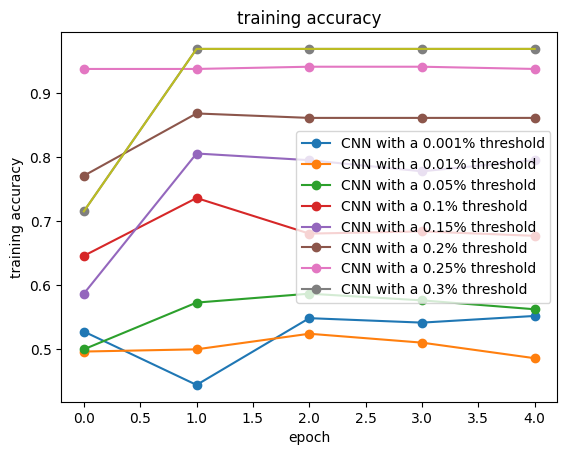

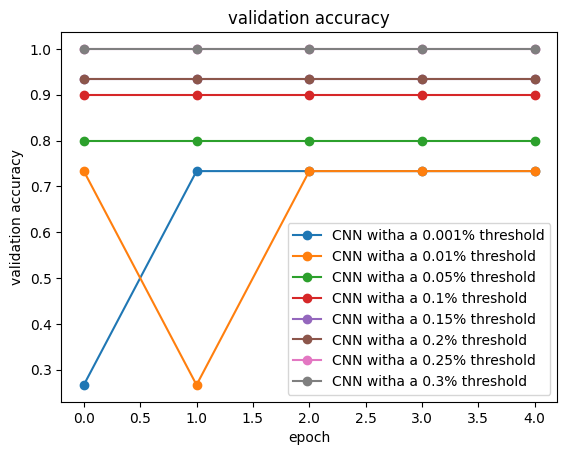

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4995 - loss: 0.7438  
Test accuracy for CNN + 0.001 optimizer: 0.5068492889404297
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5103 - loss: 0.7466 
Test accuracy for CNN + 0.01 optimizer: 0.5205479264259338
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6227 - loss: 0.6777  
Test accuracy for CNN + 0.05 optimizer: 0.6438356041908264
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7449 - loss: 0.5802  
Test accuracy for CNN + 0.1 optimizer: 0.7397260069847107
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8104 - loss: 0.4888 
Test accuracy for CNN + 0.15 optimizer: 0.8082191944122314
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8827 - loss: 0.3636 
Test accuracy for CNN + 0.2 optimizer: 0.8904109597206116
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9120 - loss: 0.3174 
Test accuracy for CNN + 0.25 optimizer: 0.9178082346916199
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9492 - loss: 0.2027 
Test

In [231]:
history_discrete_thresholds = dict()
year = '2015'
epochs = 5
batch_size = 64
features = ['Open', 'Volume']
optmizer = 'Adam'
x_test_holder = []
y_test_holder = []
thresholds = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for threshold in thresholds:
    x_train, y_train, x_val, y_val, x_test, y_test = generate_training_and_validation_data_boolean_by_year(year, threshold)
    x_train, y_train, x_val, y_val, x_test, y_test = custom_features_keras_inputs(x_train, y_train, x_val, y_val, x_test, y_test, features)
    save_best_model = ModelCheckpoint('best_model_with_threshold.{}.keras'.format(threshold), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
    model = base_cnn_opt(input_shape, optimizer)
    history_discrete_thresholds[threshold] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val, y_val),
                          shuffle=True,
                          callbacks=[save_best_model])
    x_test_holder.append(x_test)
    y_test_holder.append(y_test)

# Plot training accuracy
for model_name, history in history_discrete_thresholds.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN with a {}% threshold'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_discrete_thresholds.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN witha a {}% threshold'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
index = 0
for threshold in thresholds:
  saved_model = load_model('best_model_with_threshold.{}.keras'.format(threshold))
  scores = saved_model.evaluate(x_test_holder[index], y_test_holder[index], verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(threshold, scores[1]))
  index += 1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4995 - loss: 0.7438 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5103 - loss: 0.7466 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6227 - loss: 0.6777 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7449 - loss: 0.5802 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8104 - loss: 0.4888 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8827 - loss: 0.3636  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9120 - loss: 0.3174 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9492 - loss: 0.2027  


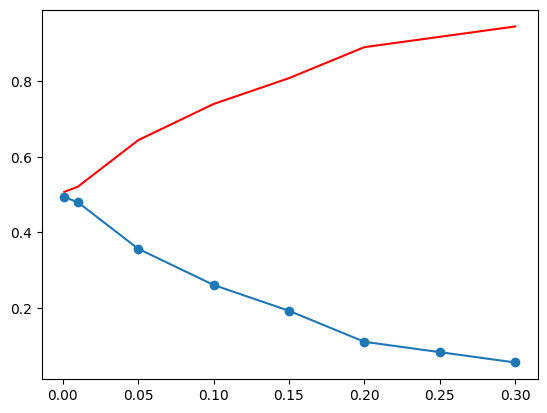

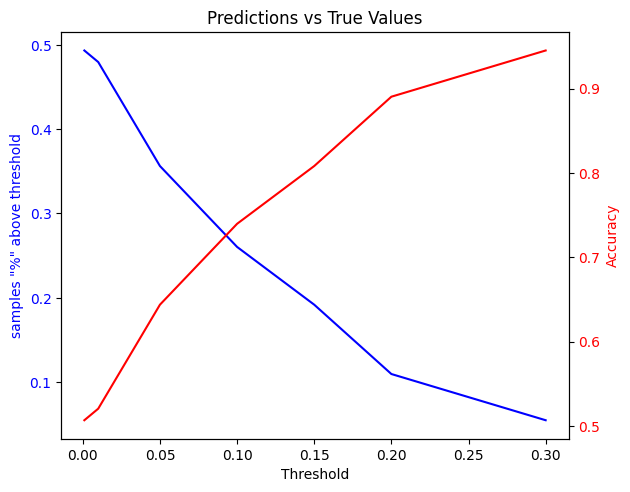

In [232]:
index = 0
accuracy_array = []
for threshold in thresholds:
  saved_model = load_model('best_model_with_threshold.{}.keras'.format(threshold))
  scores = saved_model.evaluate(x_test_holder[index], y_test_holder[index], verbose=1)
  accuracy_array.append(scores[1])
  index += 1

positive_count_array = []
for y in y_test_holder:
    positive_count = 0
    for i in range(len(y)):
        if y[i] == 1:
            positive_count += 1
    positive_count_array.append(positive_count/len(y))



plt.plot(thresholds, accuracy_array, 'r-', label = 'Accuracy')
plt.plot(thresholds, positive_count_array, 'o-', label = 'Positive count')

fig, ax1 = plt.subplots()

# Plot predictions on the primary y-axis
ax1.set_xlabel('Threshold')
ax1.set_ylabel('samples "%" above threshold', color='blue')
ax1.plot(thresholds, positive_count_array,  label='Positives', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot the true values
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(thresholds, accuracy_array, label='Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
plt.title('Predictions vs True Values')
plt.show()

In [233]:
model = load_model('best_model_with_threshold.{}.keras'.format('0.15'))
predictions = model.predict(x_test_holder[4])
print(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.22180803]
 [0.22180834]
 [0.22180831]
 [0.22180642]
 [0.22180702]
 [0.22180893]
 [0.22180788]
 [0.22180843]
 [0.22180736]
 [0.22180682]
 [0.22180842]
 [0.22180834]
 [0.22180827]
 [0.22180748]
 [0.22180822]
 [0.22180815]
 [0.22180831]
 [0.2218076 ]
 [0.22180799]
 [0.22180834]
 [0.22180834]
 [0.2218081 ]
 [0.22180678]
 [0.22180775]
 [0.22180252]
 [0.22180775]
 [0.22180721]
 [0.22180787]
 [0.22180724]
 [0.22180803]
 [0.22180831]
 [0.22180775]
 [0.22180846]
 [0.22180839]
 [0.22180803]
 [0.22180815]
 [0.22180842]
 [0.22180843]
 [0.22180687]
 [0.22180717]
 [0.22180803]
 [0.22180834]
 [0.22180757]
 [0.22180808]
 [0.22180788]
 [0.22180787]
 [0.221807  ]
 [0.22180764]
 [0.22180808]
 [0.22180626]
 [0.22180827]
 [0.2218082 ]
 [0.22179335]
 [0.22180834]
 [0.22180702]
 [0.2218081 ]
 [0.22180682]
 [0.22180487]
 [0.22180834]
 [0.22180651]
 [0.22180708]
 [0.22180839]
 [0.221807  ]
 [0.2218063 ]
 [0.22180799]
 [0.22180812]
 [0.22180788]
 [0.221806  ]
 [0.221808